As stated in the manuscript, it is essential that you run this jupyter notebook first and then tutorial-2 and then tutorial-3, so that the figures in the paper can be fully re-produced correctly.


Requirements(for all tutorials, can be installed using 'pip install package_name'): 
 
numpy, 
pandas, 
matplotlib,
tqdm,
holoviews,
biopython,
scikit-learn,
xgboost,
scipy
 
    
DATA links:

-trigram-vectors: https://dataverse.harvard.edu/dataset.xhtml?persistentId=doi:10.7910/DVN/JMFHTN (download the 'protVec_100d_3grams.csv' file, you might need to make an account in Harvard Dataverse first)

-protein sequences, features used in "Enhancing the biological relevance of reverse vaccinology classifiers" (Heinson et. al 2017), and BPA labels: https://www.mdpi.com/1422-0067/18/2/312#supplementary (download both supplementary files)

Please place the trigram vectors file in the same directory as this jupyter notebook.
For the proteins, place the 'Supplementary_Table_2.xlsx' file found in the 'New_Supementary_Tables' folder in the "Supplementary File 2" zip folder, in the same directory as this jupyter notebook.

Please enter your email to access the NCBI Entrez records (useful for constructing protein datasets)

In [1]:
entrez_email = 'fp1n17@soton.ac.uk'

In [2]:
%matplotlib inline
import pandas as pd, numpy as np, matplotlib.pyplot as plt, sys, os, collections, itertools, holoviews as hv
from tqdm import tqdm
from datetime import datetime

from sklearn.manifold import TSNE
from sklearn.preprocessing import StandardScaler,MinMaxScaler
import pickle
from sklearn.decomposition import PCA
from mpl_toolkits.mplot3d import Axes3D
#from holoviews import opts,dim
import itertools,  os
from Bio import SeqIO
from Bio import Entrez
#import xmltodict

In [3]:
'''UTILITY FUNCTIONS'''
def filter_out_rare_AAs(trigram_data):
    #filters out 3grams with rare amino acids from the 'trigram_data' dataframe
    
    #lambda for filtering
    amb_AAs = ['U','O','B','Z','J','X']
    contains_amb_AAs = lambda trigram: (any([amb_AA in trigram for amb_AA in amb_AAs]))
    
    #get list with indexes of n-grams that don't contain amb. AAs
    trigrams=trigram_data.iloc[:,0]
    indexes_amb_trigrams = [index for index,ngram in enumerate(trigrams)
                    if (contains_amb_AAs(ngram)) ] 
   
    #keep only the trigrams that don't contain ambiguous AAs
    trigram_data = trigram_data[~(trigram_data.index.isin(indexes_amb_trigrams))]
    trigram_data.reset_index(inplace=True,drop=True)
    
    return trigram_data




def make_dir(paths):
    '''creates directory path (or multiple directories if needed) if they 
    #don't exist and returns the path created
    If dir. exists, then nth is done, just path is returned!
    '''

    if isinstance(paths,list):
            
        if len(paths)>2:
            path = paths[0]
            for i in range(1,len(paths)):
                path = os.path.join(path,paths[i])
            if os.path.exists(path) == False :
                os.makedirs(path)
                
        elif len(paths)==2:
            path = os.path.join(paths[0],paths[1])
            if os.path.exists(path) == False :
                os.makedirs(path)
            
        elif len(paths)==1:
            path = paths[0]
            if os.path.exists(path) == False :
                os.mkdir(path= path)
                
        else:
            raise ValueError('Length of list of paths has to be larger than 0')


    elif isinstance(paths,str):
        path = paths
        if os.path.exists(path) == False :
            os.mkdir(path= path)
    
    else:
        raise TypeError('Argument @paths must be list of strings or a string, indicating the dir.path')
    #all paths don't have '/' in the end!
    return path

    
def store_feature_selection_result_data(bpas_name_seq, prot_vecs,bpas_label,filename):
    '''convenience function for storing results of clustering/normalization on protein vectors'''
    #TODO: move this fn to convenience functions class
    
    bpas_name_seq.reset_index().drop('index', axis=1,inplace=True)
    bpas_label.reset_index().drop('index', axis=1,inplace=True)
    
    cols=[]
    for ind in range(len(prot_vecs[0])):
        cols.append('Feature_'+str(ind))
    prot_vecs_df=pd.DataFrame(prot_vecs,columns=cols,index=np.arange(len(prot_vecs)))
    
    bpas_hc_vecs_df = pd.concat([ bpas_name_seq , prot_vecs_df, 
                                 bpas_label ],axis=1)
    
    bpas_hc_vecs_df.to_csv(filename)
    
    return bpas_hc_vecs_df


def visualise_pcs(data,expl_var,dim_red_path):
        #TODO: fix complexity
        print('Generating and storing visualizations of results..\n')
        assert set(['Label','Accession','Sequence']).issubset(data.columns)
        data.set_index('Label',drop=True,inplace=True)
        if isinstance(data.index, np.string_)==False:
            data.index = data.index.astype(np.string_)
            indic = data.index.tolist()
            data.index = [i.decode('utf-8') for i in indic]
        
        fig, ax = plt.subplots(figsize=(15, 20), nrows=1, ncols=1, sharex='col')
        
        ax.scatter(data.loc['1', 'Feature_0'], data.loc['1', 'Feature_1'],marker='x',label='1')
        ax.scatter(data.loc['-1', 'Feature_0'], data.loc['-1', 'Feature_1'],marker='o',label='-1')
        
        #better not to draw axes ticks, as PC elements have to be rotated based on the principal directions
        ax.set(xlabel="pc1", ylabel="pc2")
        ax.legend()
        ax.grid(True)
        plt.savefig(dim_red_path+'\\PCA_first_2_PCs.png')
        plt.show(fig)
        #plt.close(fig)
        
        #reset dataset as it was 
        data.reset_index(inplace=True,drop=False)
        data.rename({'index':'Label'},axis=1,inplace=True)
        cols = data.columns[1:].tolist()
        cols.append('Label')
        data.columns = cols
        
        
    

In [4]:
'''setting data Paths'''
prots_path='./Supplementary_Table_2.xlsx'
trigrams_path='./protVec_100d_3grams.csv'

date_time = datetime.now().strftime("%d-%m-%Y_%H-%M-%S")
d_path = make_dir(['tut-1-PCA-optimal-model'])#,date_time,])

In [5]:
'''ASSEMBLE PROTEINS DATASET (for easier loading and use afterwards in this notebook)'''

#load Supplementary_Table_2.xlsx file
#this file is a bit unstructured and is missing the sequence of each protein
## all features are scaled to be between -1 and 1
top10_feats=['LipoP_Signal_Avg_Length','YinOYang-T-Count','NetPhosK-S-Count','LipoP_SPI_Avg_Length','NetMhcPan-B-AvgRank','TargetP-SecretFlag','YinOYang-AvgDiff1','MBAAgl7_CorCount','PickPocket-Avg','PropFurin-Count_Score']
cols1 = ['Id','Length']
cols1.extend(top10_feats)
cols1.extend(['Label'])

prots_data = pd.read_excel(prots_path
                             ,usecols = cols1,index_col=None
                            ,skiprows=[0,1])


In [6]:
'''Cell has large time complexity (around 5 mins to run)'''

#load the ijms-18-00312-s001.fa file to get the sequence of each protein
#TODO: 'ijms-18-00312-s001.fa' does not have sequences for all proteins...!!!!
#and also has different accession names than NCBI protein db (extra/missing '.' , '_' and other characters)

#get the sequences from NCBI 
#check 'Entrez Guidelines' http://biopython.org/DIST/docs/tutorial/Tutorial.html#chapter%3Aentrez
#code ref: https://www.ncbi.nlm.nih.gov/dbvar/content/tools/entrez/
seqs=[]
Entrez.email  = entrez_email
db = 'Protein'

for i,acc in enumerate(prots_data.loc[:,'Id'].values.tolist()):
    if i%50==0:
        print('Protein sequences collected: ',i,'   Current protein collected: ',acc,'\n')
    #testing
    #print(seqs,'\n',acc,'\n')
    try:
        handle = Entrez.efetch(db="protein", id=acc, rettype="gb", retmode="text")
    except Exception:
        if '_' not in acc:
            acc = acc+'_A' 
            try:
                handle = Entrez.efetch(db="protein", id=acc, rettype="gb", retmode="text")
            except Exception:
                if '.' not in acc:
                    acc = acc[:-2]+'.1'
                    handle = Entrez.efetch(db="protein", id=acc, rettype="gb", retmode="text")
    
    record = SeqIO.read(handle, "genbank")
    handle.close()
    
    seqs.append(str(record.seq))


Protein sequences collected:  0    Current protein collected:  1DI0_A 



C:\Users\Stelios\anaconda3\envs\Frixos\lib\site-packages\Bio\GenBank\__init__.py:1139: BiopythonParserWarning: Dropping bond qualifier in feature location
  warnings.warn(


Protein sequences collected:  50    Current protein collected:  AAM22954.1 

Protein sequences collected:  100    Current protein collected:  NP_216402.1 

Protein sequences collected:  150    Current protein collected:  NP_854596.1 

Protein sequences collected:  200    Current protein collected:  NP_206845.1 

Protein sequences collected:  250    Current protein collected:  YP_001198726.1 

Protein sequences collected:  300    Current protein collected:  YP_002740654.1 

Protein sequences collected:  350    Current protein collected:  YP_007968918.1 



In [7]:
#testing
len(set(seqs))

400

In [8]:
#create proteins dataset and store in the desired format for use later on

prots_data = pd.concat([prots_data.iloc[:,0],pd.DataFrame(seqs,columns = ['Sequence']),prots_data.iloc[:,1:]],axis=1)
#prots_data.columns=cols_
prots_data.rename({'Id':'Accession'},inplace=True,axis=1)
prots_data.to_csv('./BPAD200.csv',index=None)

In [9]:
#prots_data

In [10]:
'''FUNCTIONS HANDLING MAIN TUTORIAL LOGIC'''

'FUNCTIONS HANDLING MAIN TUTORIAL LOGIC'

In [11]:
def sum_trigrams(trigram_vecs,prot_data,d_path):
    ##reference: https://www.biostars.org
    '''use sequence to derive 100d vector for each protein, by summing up the overlapping
    trigram 100d vectors in the sequence'''
    
    print('\nBuilding protein vectors from summing up overlapping 3grams in sequence..\n')
    
    
    # set the index of trigrams_vecs df to the actual trigram, for optimizing lookups
    trigram_vecs.set_index('words',inplace=True,drop=True)

    #testing
    assert trigram_vecs.shape[1]==100
    
    #init variables
    prot_vecs = np.zeros(shape=(len(prot_data), trigram_vecs.shape[1] ), dtype=float)
    prots = list(prot_data.loc[:,'Sequence'].values)
    
    # checking the progress as we go
    progressbar = tqdm(prots)
    
    #loop over all sequences in bpad200
    for seq_ind,seq in enumerate(progressbar):
        # split sequence into overlappling 3grams and then sum them
        curr_trigrams = [ seq[i:i + 3] for i in range(0, len(seq) - 2, 1) ]
        
        #lookups up the 3gram in trigram_vecs and assigns its 100d vector
        for trigram in curr_trigrams:
            try:
                t_vec = trigram_vecs.loc[trigram,:].values
            except (KeyError):
                t_vec = trigram_vecs.loc['<unk>',:].values
                
            #t_vec then added to the current protein vector being constructed
            #, to build sequence vec. of sum of overlapping 3grams
            prot_vecs[seq_ind] += t_vec
    
        #print progress
        progressbar.set_description('Processed protein: '+str(seq_ind))
     
    #testing block
    arr_types = []
    for i in prot_vecs:
        arr_types.append(np.array(list(i)).dtype=='float64')
    res  = all(arr_types)
    assert len(prot_vecs)==len(prot_data) and res          
    
    #store protvecs to file
    filename='prot_vecs_sum_trigrams'
    filepath = d_path+'\\'+filename+'.csv'
    cols = ['Feat_'+str(i) for i in range(prot_vecs.shape[1]) ]
    prot_vecs = pd.concat([prot_data.iloc[:,:2]
                             ,pd.DataFrame(prot_vecs,columns=cols)
                             ,prot_data['Label'] ]
              ,axis=1 )
    prot_vecs.to_csv(filepath)
    
    return prot_vecs



def data_scaling(dataset,method,data_scale_path):
    #scale/standardise data before feature selection (eg: before PCA)
    print('Preprocessing data for PCA')

    if method=='standardise':
        #here we get dataset with column mean=0,col. variance=1
        ss = StandardScaler()
        ss.fit(dataset.drop(['Accession','Sequence', 'Label'], axis=1))
        dataset_scaled = ss.transform(
                dataset.drop(['Accession','Sequence', 'Label'], axis=1))
        #store object for use in model deployment
        #pickle.dump(ss,open(data_scale_path+'\\Standard_Scaler.pkl','wb'))

    elif method=='scaling_AH':
        #transform range of values for each feature to (-1, 1)
        mms = MinMaxScaler(feature_range=(-1, 1))
        mms.fit(dataset.drop(['Accession'
                    ,'Sequence', 'Label'], axis=1)) 
        dataset_scaled = mms.transform(dataset.drop(['Accession'
                             ,'Sequence', 'Label'], axis=1)) 
        #store object for use in model deployment
        #pickle.dump(mms,open(data_scale_path+'\\MinMaxScaler.pkl','wb'))
    
    dataset = pd.concat([dataset.iloc[:,:2],pd.DataFrame(dataset_scaled),dataset.iloc[:,-1]],axis=1)
    #dataset.to_csv(data_scale_path+'\\prot_vecs.csv')

    return dataset


In [12]:

def pca_(ds_method,dr_method,dataset,dim_red_path,num_iters):
    dim_red_results={'Data_scaling_method':[],'Data_reduction_method':[]
                     ,'Explained_variance':[],'Num_of_PCs':[]}
    n_comp_list=[]
    expl_variance_values = np.linspace(0.90,0.99,num_iters,endpoint=True)

    for expl_variance in expl_variance_values:
        #n_comp,prot_pcs, expl_var = self._pca_(dataset_name,dataset,expl_variance,dim_red_path)
        print('Performing PCA, aiming to retain ',str(expl_variance),' of the variation in the original dataset')
    
        pca = PCA(n_components=expl_variance,svd_solver = 'full',random_state=10)
        pca.fit(dataset.drop(['Accession','Sequence','Label'],axis=1))
        
        prot_pcs =  pca.transform(dataset.drop(['Accession','Sequence','Label'],axis=1))
        n_comp = len(prot_pcs[0])
        expl_var = pca.explained_variance_ratio_
        
        print('Storing PCA results..')
        #pd.DataFrame(expl_var,columns=['expl_var']).to_csv(d_path+'\\PCs_expl_var_ratio.csv')
        #pickle.dump(pca,open(d_path+'\\PCA_'+str(n_comp)+'.pkl','wb'))    
        
        n_comp_list.append(n_comp)
        

    prot_pcs = store_feature_selection_result_data(dataset.iloc[:, :2],prot_pcs,dataset.iloc[:,-1],dim_red_path+'\\PCs.csv')

    #FINDING OUTLIERS OF first dims of PCs constructed
    #Eda = exploratory_da(prot_pcs,dim_red_path)
    #Eda.find_outliers()

    visualise_pcs(prot_pcs,expl_var,dim_red_path)

    #save results of all hyperparams runs of this dim.red method, of this scaling method
    dim_red_results.update( { 'Data_scaling_method':[ ds_method for i in range(len(expl_variance_values))],
                                                     'Data_reduction_method':[ dr_method for i in range(len(expl_variance_values))],
                             'Explained_variance':list(expl_variance_values),'Num_of_PCs':n_comp_list} )

    return dim_red_results

In [13]:
'''MAIN ALGORITHM FLOW STARTS'''

'MAIN ALGORITHM FLOW STARTS'

In [14]:
'''LOAD DATA'''

prots_path = './BPAD200.csv'

'''load proteins'''
#load bpad200 proteins
dataset = pd.read_csv(prots_path
                      ,index_col=None,usecols=['Accession','Sequence','Label'])
#dataset.reset_index(inplace=True,drop=False)

# handling empty lines between protein records dataset given
if len(dataset)>400:
    dataset= dataset[1::2]
    dataset.reset_index(drop=False,inplace=True)

# testing
assert len(dataset)==400

In [15]:
dataset

,Accession,Sequence,Label
0,1DI0_A,MNQSCPNKTSFKIAFIQARWHADIVDEARKSFVAELAAKTGGSVEV...,1
1,1DYQ,MSEKSEEINEKDLRKKSELQGTALGNLKQIYYYNEKAKTENKESHD...,1
2,2Y1V_C,GAGTTTTSVTVHKLLATDGDXDKIANELETGNYAGNKVGVLPANAK...,1
3,A46405,MFRRSKNNSYDTSQTKQRFSIKKFKFGAASVLIGLSFLGGVTQGNL...,1
4,AAA20874.1,MNKNVLKFMVFIMLLNIITPLFNKNEAFAARDISSTNVTDLTVSPS...,1
...,...,...,...
395,YP_222757.1,MFRWGVLSTAKIGVTQVIPALAASDNGVVHAIASRDHARARAVAGR...,-1
396,YP_695964.1,MQDKNPLSTFGPDLNEFSRDVNFLTLAKNSDFIYLRASGSGTGKLR...,-1
397,YP_696046.1,MNSLQRFRLSKNLSRSEIAKLLGISESYYTKIELGIRNPSYNFLKK...,-1
398,YP_763859.1,MKKIPLIISLTASMSFGIALAAEAKAPVTQVQDSSESSPIAQGEGK...,-1


In [16]:
'''load trigrams'''
trigrams_cols='infer'
trigrams_ind=None
trigram_vecs = pd.read_csv(trigrams_path, header=trigrams_cols, 
                            index_col=trigrams_ind, delimiter='\t')


#keep only the 8000 3grams, corresponding to non-amb. AAs
trigram_vecs = filter_out_rare_AAs(trigram_vecs)

trigram_vecs

,words,d1,d2,d3,d4,d5,d6,d7,d8,d9,...,d91,d92,d93,d94,d95,d96,d97,d98,d99,d100
0,AAA,-0.174060,-0.095756,0.059515,0.039673,-0.375934,-0.115415,0.090725,0.173422,0.292520,...,0.244482,0.015974,0.012903,0.137528,0.138140,0.005474,0.070719,-0.164084,-0.179274,0.184899
1,ALA,-0.114085,-0.093288,0.155800,-0.037351,-0.121446,0.084037,0.023819,0.093442,0.143256,...,0.075584,-0.139661,0.034863,0.056078,0.028975,-0.012233,0.059669,0.037811,-0.172493,0.074655
2,LLL,-0.075594,-0.100834,-0.046616,-0.208980,-0.008596,-0.038612,-0.049360,0.060720,-0.062662,...,0.174677,-0.175961,-0.193242,-0.072965,-0.075560,0.158286,-0.026378,0.037155,-0.176038,0.319293
3,LAA,-0.137546,-0.135425,0.121566,-0.038295,-0.212129,0.040009,0.078545,0.029837,0.138343,...,0.133947,-0.156484,-0.048541,0.141848,0.081842,0.070573,0.006927,0.035281,-0.138971,0.105997
4,AAL,-0.156112,-0.133524,0.114426,-0.020264,-0.058513,0.057005,0.076881,0.054781,0.129436,...,0.154597,-0.050440,0.054866,0.066185,0.017498,0.001773,-0.083944,-0.003867,-0.106367,0.070706
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7996,MCW,0.189675,-0.217609,-0.074782,-0.173070,-0.045159,-0.035383,-0.004494,-0.031810,-0.373650,...,-0.099728,0.016810,-0.457353,-0.037701,-0.141955,0.120171,-0.187709,-0.050582,-0.180618,0.076437
7997,CWW,-0.037902,0.189432,-0.086886,-0.040657,-0.271983,-0.110906,-0.113560,0.227602,-0.067016,...,0.108387,0.133419,-0.138808,-0.027101,-0.048607,0.317402,-0.249209,-0.312932,-0.219881,0.078666
7998,WWC,0.081520,0.056546,0.023758,0.012273,-0.211017,0.125700,0.009594,-0.200793,-0.507447,...,-0.358598,0.426380,-0.111767,-0.165190,-0.213001,0.004355,-0.063989,-0.390067,-0.218317,0.194550
7999,WCM,-0.161819,-0.068646,0.135300,-0.145919,-0.183953,-0.149977,0.175221,-0.014058,-0.360929,...,-0.216097,0.145029,-0.162594,-0.152331,-0.128453,0.210622,-0.064518,-0.317583,-0.355061,0.437933


In [17]:
'''Pre-processing'''

#path for saving data generated through this tutorial
d_path = make_dir([d_path,'pre_processing'])
prot_vecs = sum_trigrams(trigram_vecs,dataset,d_path)

#prot_vecs

Processed protein: 1:   0%|          | 2/400 [00:00<00:30, 13.22it/s]


Building protein vectors from summing up overlapping 3grams in sequence..



Processed protein: 399: 100%|██████████| 400/400 [00:37<00:00, 10.57it/s]


Preprocessing data for PCA
Performing PCA, aiming to retain  0.9  of the variation in the original dataset
Storing PCA results..
Performing PCA, aiming to retain  0.9450000000000001  of the variation in the original dataset
Storing PCA results..
Performing PCA, aiming to retain  0.99  of the variation in the original dataset
Storing PCA results..
Generating and storing visualizations of results..



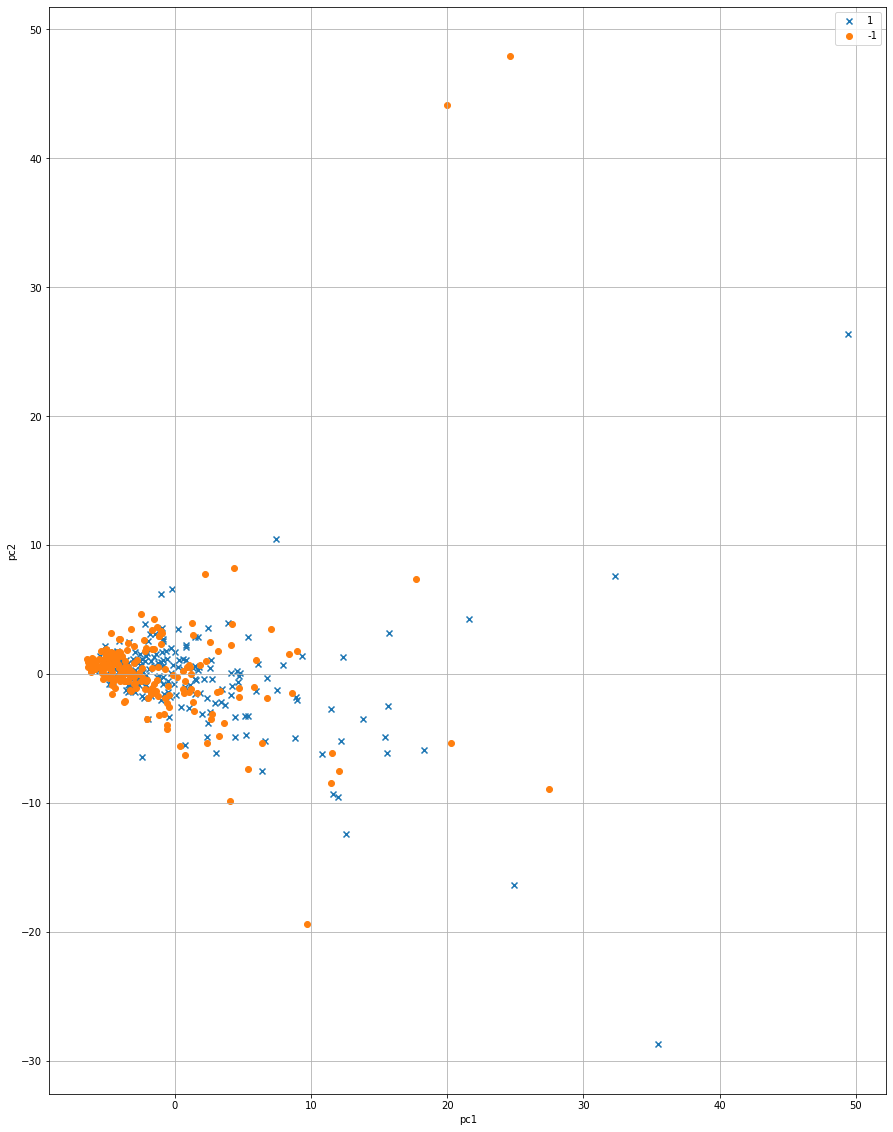

In [18]:
'''Scaling and applying PCA'''
runs_details={}
data_scaling_methods = ['standardise']#'scaling_AH'] 
dim_red_methods = ['PCA'] #Tsne, kernel pca etc.
#prot_data_name = prot_path.split('.csv')[0]


for ds_method in data_scaling_methods:
    data_scale_path = make_dir([d_path,ds_method])
    prot_vecs = data_scaling(prot_vecs,ds_method,data_scale_path)

    for dr_method in dim_red_methods:    
        dim_red_path = make_dir([data_scale_path,dr_method])

        ### EDA  ?
        
        num_iters=3
        run_details_ = pca_(ds_method,dr_method,prot_vecs,dim_red_path,num_iters) 

        for key in run_details_.keys():
            runs_details.setdefault(key,[]).extend(run_details_[key])
        '''#todo: check other implementations on what hyperaparameter values they used!
        #n_components = 3, perplexity = 30, learning_rate = 200, method = 'exact', verbose=1
        hyperparams = [ [10,20,30,40,50],[100,200,500,750] ]
        all_comb = (itertools.product(*hyperparams))
        for hyperparam_comb in all_comb:
            tsne(entry[0],entry[1],d_path, hyperparam_comb)
        '''
#(pd.DataFrame.from_dict(runs_details)).to_csv(dim_red_path+'\\runs_details.csv')


The PCA plot in the paper can also be found as "PCA_first_2_PCs.png" 
in the "\pre_processing\standardise\PCA" folder in the directory where this jupyter notebook is placed


The protein labels for the outliers were added during the writing of the manuscript using Microsoft Excel and some formatting was applied on the visualisation.
